# CIFAR3 perfect discrimination transformation:

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression
import torch
from torch import nn

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

In [5]:
%matplotlib inline
np.random.seed(1)

## Load data

In [6]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

## Define Invertible MLP:

In [7]:
class InvertibleLayer(nn.Module):
    def __init__(self, dim):
        super(InvertibleLayer, self).__init__()
        
        # Initialize Parameters:
        self.w1 = nn.Parameter(torch.randn(dim, dim))
        self.w2 = nn.Parameter(torch.randn(dim, dim))
        self.w3 = nn.Parameter(torch.randn(dim, dim))
        self.b = nn.Parameter(torch.randn(dim))
        
        self.perm2 = torch.LongTensor([1,2,0])
        self.perm3 = torch.LongTensor([2,0,1])
        
        
    def forward(self, x):
        
        w1 = torch.tril(self.w1)
        w2 = torch.tril(self.w2)
        w3 = torch.tril(self.w3)
        
        y = torch.matmul(x, w1) + torch.matmul(x, w2[:, self.perm2]) + torch.matmul(x, w3[:, self.perm3]) + self.b
        
        return y

In [8]:
class InvertibleMLP(nn.Module):
    def __init__(self, layers, dim):
        super(InvertibleMLP, self).__init__()
        
        self.layers = nn.ModuleList(InvertibleLayer(dim) for _ in range(layers))
        self.softmx = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        for l in self.layers[:-1]:
            x = torch.tanh(l(x))
            
        y = self.softmx(self.layers[-1](x))
        
        return y

## Train Invertible MLP:

In [9]:
mlp = InvertibleMLP(10, 3)

CE = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.00001)

In [10]:
epochs = 1000
batch_size= 20


loss = []

torch_logits = torch.as_tensor(logits, dtype=torch.float)
torch_target = torch.as_tensor(np.argmax(target, axis=1), dtype=torch.long)

for e in range(epochs):
    r = torch.randperm(logits.shape[0])
    torch_logits = torch_logits[r]
    epoch_loss = []
    for step in range(logits.shape[0]//batch_size):
        pred = mlp(torch_logits[step*batch_size:(step+1)*batch_size, :])
    
        _loss = CE(pred, torch_target[step*batch_size:(step+1)*batch_size])
        epoch_loss.append(_loss.item())
        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()
        
    loss.append(sum(epoch_loss)/len(epoch_loss))

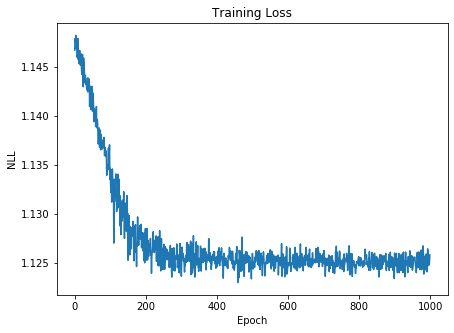

In [11]:
# Plot training NLL
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(loss)
ax.set_title('Training Loss')
ax.set_ylabel('NLL')
ax.set_xlabel('Epoch')

plt.show()

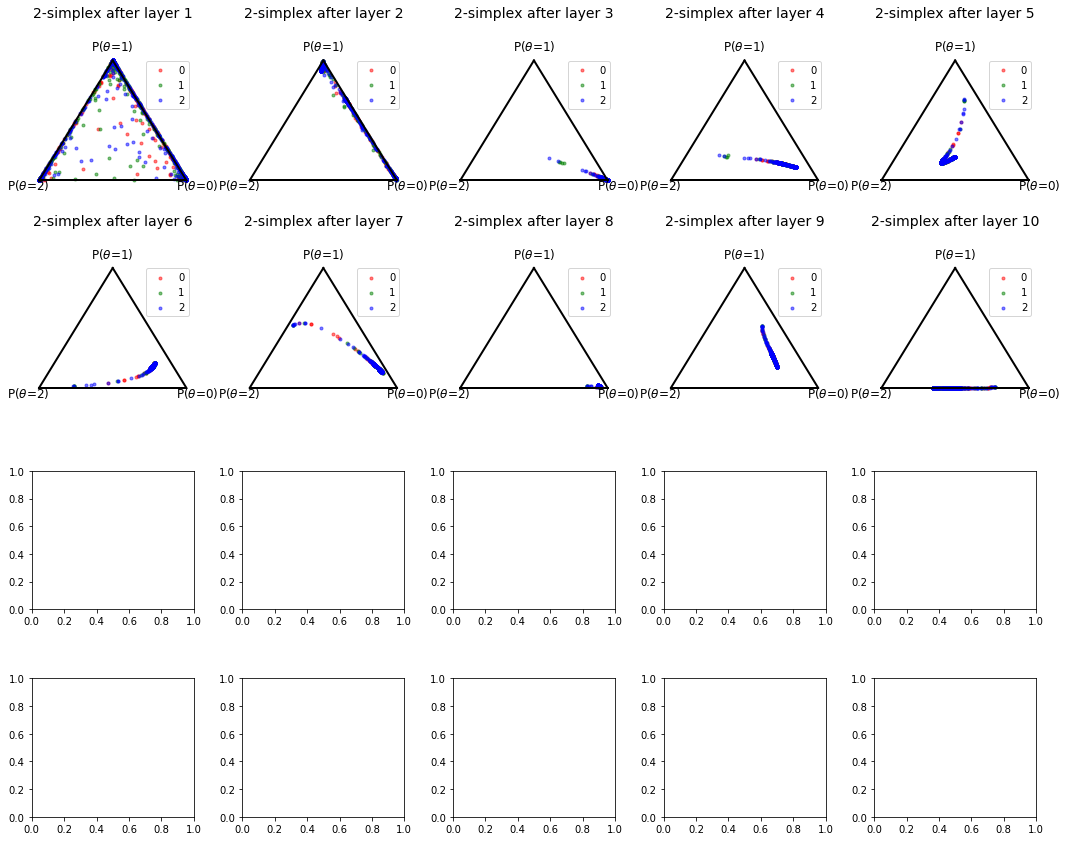

In [12]:
fig, ax_arr = plt.subplots(4, 5, figsize=(18, 14), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
layers = []
for i, layer in enumerate(mlp.layers):
    layers.append(layer)
    def model(x):
        for j, _layer in enumerate(layers):
            x = _layer(x)
            if j < len(layers)-1:
                x = torch.tanh(x)
        return softmax(x.cpu().detach().numpy(), axis=1)
    ax_arr[i//5, i%5] = plot_prob_simplex(model(torch_logits), target=target, ax=ax_arr[i//5, i%5], scale=60,
                                         title='2-simplex after layer {}'.format(i+1),
                                         fontsize=12);
    
plt.show()

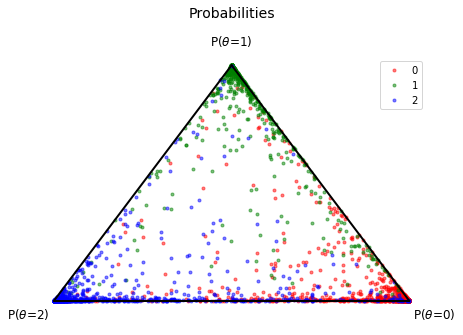

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = plot_prob_simplex(probs, target=target, ax=ax)

plt.show()

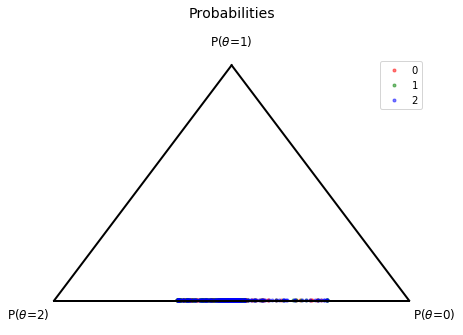

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = plot_prob_simplex(model(torch_logits), target=target, ax=ax)

plt.show()

In [15]:
mlp.layers[-1].w2

Parameter containing:
tensor([[ 0.9801,  0.7373, -1.2751],
        [-1.5050,  1.4303,  0.3355],
        [-1.7764, -1.6329,  1.0466]], requires_grad=True)

In [16]:
torch.tril(mlp.layers[-1].w2)[:, mlp.layers[-1].perm2]

tensor([[ 0.0000,  0.0000,  0.9801],
        [ 1.4303,  0.0000, -1.5050],
        [-1.6329,  1.0466, -1.7764]], grad_fn=<IndexBackward>)